# Investment and Trading Capstone Project

## Build a Stock Price Indicator

### project overview

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process. 

This project uses this historical stock prices from finnhub.io to make predictions on the development of these stocks. The result of this process will implememnted in a website giving the user the possibility to choose a certain timeframe or stock to analyze.

### problem statement

The problem to be tackled in this project is to predict future adjsuted stock closing prices for certain stocks. To do so we will make use of several regression and deep learning models to achieve a maximum of accuracy for our predictions. 
The user interaction of this project will be implemented in a website/dashboard. There it will be possible to choose the stock of interest and a certain timeframe to predict data for the fututre.

## Exploratory Data Analysis

In this part we will have a closer look at the underlying data to decide how exactly we will deal with it in order to achieve the above mentioned results. Let's read in some libraries and the data first.

In [1]:
import sys
print(sys.path)
print(sys.executable)

['c:\\Users\\yvesd\\Udacity\\Data Scientist\\stock_forecast', 'C:\\Program Files\\Microsoft VS Code', 'c:\\Users\\yvesd\\.vscode\\extensions\\ms-python.python-2020.8.101144\\pythonFiles', 'c:\\Users\\yvesd\\.vscode\\extensions\\ms-python.python-2020.8.101144\\pythonFiles\\lib\\python', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\python38.zip', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\DLLs', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks', '', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\win32', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\win32\\lib', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\Pythonwin', 'C:\\Users\\yvesd\\miniconda3\\envs\\stocks\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\yvesd\\.ipython']
C:\Users\yvesd\miniconda3\envs\stocks\python.exe


In [24]:
import warnings
import itertools
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from functools import reduce
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

### data

We obtain our data from an API at www.finnhub.io. We're especially interested in the candlestick data for stocks going back 25 years for US stocks. As an example in this notebook we choose to work the the Google stock (GOOG).

In [3]:
def convert_timestamp_to_unix(timestamp):
    """Converts a pandas timestamp to a unix integer."""
    return (timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

def convert_unix_to_timestamp(unix):
    """Converts a unix integer into a pandas datetime object."""
    return pd.to_datetime(unix, unit='s')

In [4]:
def get_ohlc_data(symbols, timedelta='5y'):
    """
    Queries list of stock symbols for their OHLC data.
    Arguments:
    symbols - list of strings containing the stock symbol of the desired stock
    Returns:
    ohlc_data - dict of dataframes containing ohlc data for each symbol over certain timeframe
    """
    ohlc_data = dict()
    # get start & endtime for ohlc data
    end_time = datetime.now()
    start_time = end_time - pd.Timedelta(timedelta)
    # convert times in unix integers for API request
    to_time = convert_timestamp_to_unix(end_time)
    from_time = convert_timestamp_to_unix(start_time)

    # get OHLC data for each symbol
    for symbol in symbols:
        r = requests.get(
            'https://finnhub.io/api/v1/stock/candle?symbol={}&resolution=D&from={}&to={}&adjusted=true'.format(
            symbol, from_time, to_time))

        data = pd.DataFrame(
            index= [convert_unix_to_timestamp(x).date() for x in r.json()['t']],
            data = {'open': r.json()['o'],
                    'high': r.json()['h'],
                    'low': r.json()['l'],
                    'adj_close': r.json()['c'],
                    'volume': r.json()['v']})
        ohlc_data.update({symbol: data})
    
    return ohlc_data

In [5]:
def plot_ohlc(symbols):
    """
    Plots the ohlc data for a given symbol and timeframe.
    Arguments:
    symbols - list of strings representing the name of a stock symbol that is contained in the ohlc dictionary.
    Returns:
    None
    """
    for symbol in symbols:
        
        df = ohlc_data[symbol]
        
        fig = go.Figure(data=[
            go.Candlestick(
                name=symbol,
                x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.adj_close)])

        fig.update_layout(
            xaxis_rangeslider_visible=False,
            title='OHLC Stock Chart for: {}'.format(symbol))
        fig.show()

In [6]:
symbols = ['GOOG']
ohlc_data = get_ohlc_data(symbols)

ohlc_data['GOOG'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2015-08-24 to 2020-08-21
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1259 non-null   float64
 1   high       1259 non-null   float64
 2   low        1259 non-null   float64
 3   adj_close  1259 non-null   float64
 4   volume     1259 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0+ KB


We can see that we got back a complete dataset without any null values. There is no further cleaning required.

In [7]:
plot_ohlc(symbols)

Above we mentioned that there are no missing values in our datasets. However, zooming in we can observe gaps in both of the graphs above. This is due to the fact that the stock markets are closed on weekends and certain holidays. This shouldn't be a problem for our prediction as we want to predict for predefined steps in the future like 7 or 30 days. So we're predicting for a certain amount of business days in the future and the actual date doesn't really matter.

For our model we want to de

In [8]:
def transform_data(original_data):
    """
    Transforms data in normal distributed series via SQRT transformation and plots results.
    
    Arguments:
    original_data - untransformed data series
    Returns:
    transformed_data - sqrt transformed data series
    """
    transformed_data = np.sqrt(original_data)
    
    # creating axes to draw plots 
    fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
    # plotting original data and transformed data
    ax[0].hist(original_data, color ="blue")
    ax[0].set_title('Original')
    ax[1].hist(np.sqrt(original_data), color ="blue") 
    ax[1].set_title('SQRT-Transform')
    
    return transformed_data

In [9]:
def split_data(timeseries, len_forecast=30):
    """
    Split timeseries into test and train dataset.
    Arguments:
    timeseries - timeseries to be split
    len_forecast - number of days to predict
    Returns:
    train_data - timeseries of train data values
    test_data - timeseries of train data values
    """
    train_data = timeseries[:-len_forecast]
    test_data = timeseries[-len_forecast:]
    
    return train_data, test_data

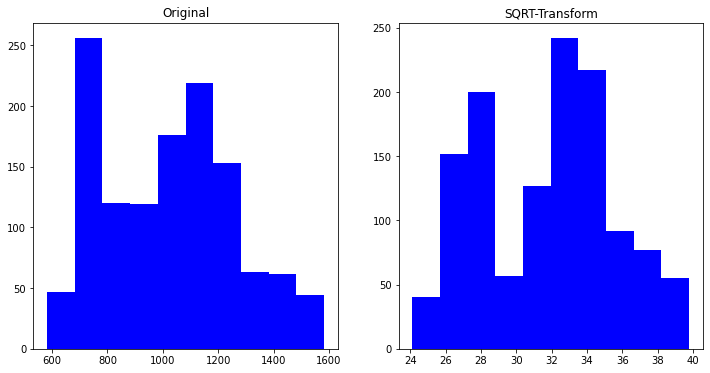

In [10]:
y = transform_data(ohlc_data['GOOG'].adj_close)
y_train, y_test = split_data(y)

## Algorithm Evaluation

In this chapter we will have a look on different models to predict stock prices and evaluate their performance to decide which algorithm to implement in the final stock price predictor.

In [11]:
def plot_autocorrelation(y):
    """Plots the AutoCorrlation for a lag to 6."""

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # The axis coordinates for the plots
    ax_idcs = [(0, 0),(0, 1),(0, 2),(1, 0),(1, 1),(1, 2)]

    for lag, ax_coords in enumerate(ax_idcs, 1):
        ax_row, ax_col = ax_coords
        axis = axes[ax_row][ax_col]
        axis.scatter(y_train[:-lag], y_train[lag:])
        axis.set_title('Lag={}'.format(lag))

    plt.show()

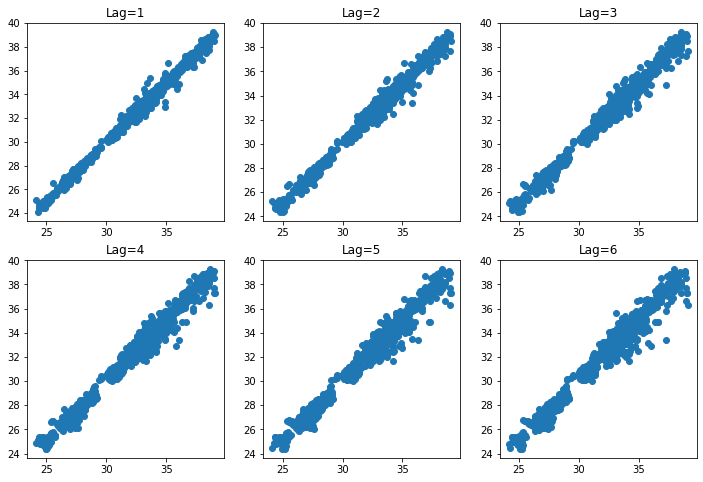

In [12]:
plot_autocorrelation(y_train)

All of the above lag graphs look fairly linear. This is a good indicator that an auto-regressive model is a good choice. We want to have a look on the ARIMA model in particular. Therefore, we'll allow the auto_arima to select the lag term for us.

In [39]:
def find_param_set(y, max_order):
    """
    Finds the optimal parameter set as input for ARIMA model by comparing AIC scores.
    
    Arguments:
    y - timeseries to fit 
    Returns:
    param - tuple (p, d, q) of best parameter set 
    """
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, max_order)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    
    results_df = pd.DataFrame(columns=['params', 'aic'])

    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            trend='t',
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            results_df = results_df.append({'params': param, 'aic': results.aic}, ignore_index=True)
        except:
            continue
    
    results_df = results_df.sort_values('aic')
    
    print("The best parameter set for the ARIMA model is: {} with an AIC of: {}"
          .format(results_df.iloc[0].params, results_df.iloc[0].aic))

    return results_df.iloc[0].params

In [40]:
p, d, q = find_param_set(y_train, 6)

The best parameter set for the ARIMA model is: (5, 1, 4) with an AIC of: 201.4593002335613


Now that we found the optimal set of parameters for the ARIMA model we will have a more detailed lokk at it. Let's fit the model with these parameters and have  a look at the results.

In [47]:
model = sm.tsa.statespace.SARIMAX(
    y_train,
    order=(p, d, q),
    trend='t',
    enforce_stationarity=False,
    enforce_invertability=False)
fitted_model = model.fit(disp=False)

In [48]:
fitted_model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

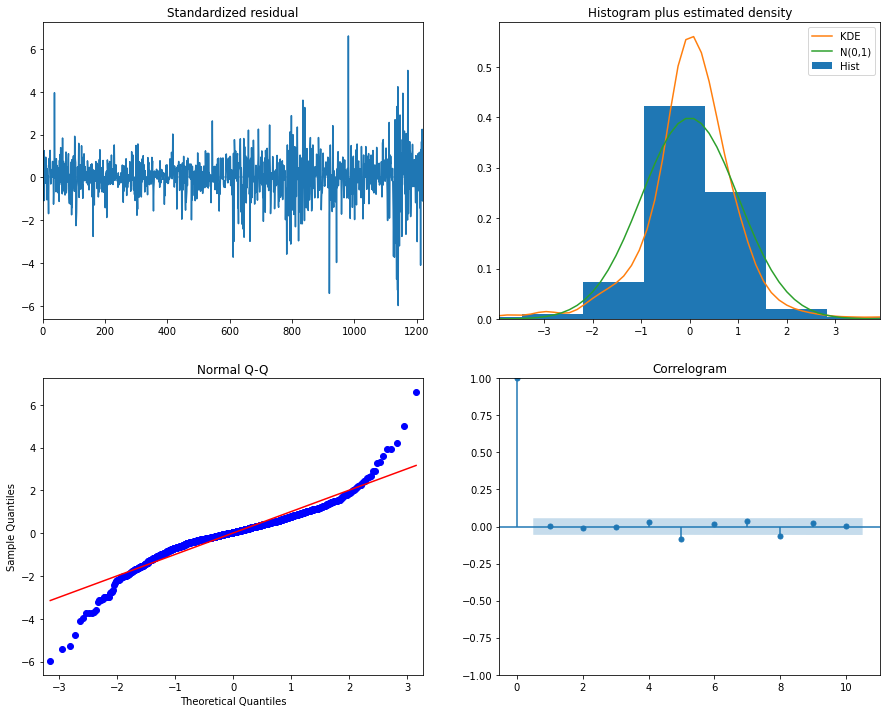

In [49]:
fitted_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [127]:
def make_forecast(len_forecast):
    """Predict values for the next X business days and plots results.
    Arguments:
    len_forecast - integer with number of days to predict
    Returns:
    None
    """

    pred = fitted_model.get_prediction(
        start=y_train.shape[0] + 1, 
        end=y_train.shape[0] + y_test[:len_forecast].shape[0], 
        dynamic=False)
    pred_ci = pred.conf_int()

    evaluate_prediction(pred, pred_ci, len_forecast)

In [128]:
def evaluate_prediction(pred, pred_ci, len_forecast):
    """
    Plot predicted values vs actual test data.

    Arguments:
    pred - model object with predicted values
    pred_ci - dataframe with data for confidence interval
    len_forecast - integer with number of days to predict
    Returns:
    None
    """

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # --------------------- Actual vs. Predicted --------------------------
    ax.plot(y_train[-len_forecast:], color='blue', label='Training Data')
    ax.plot(y_test[:len_forecast].index, pred.predicted_mean, color='green', marker='o',
                label='Predicted Price')

    ax.plot(y_test[:len_forecast].index, y_test[:len_forecast], color='red', label='Actual Price')
     # add confidence intervall
    ax.fill_between(y_test[:len_forecast].index,
                        pred_ci['lower adj_close'], 
                        pred_ci['upper adj_close'],
                        alpha=0.4, color='grey',
                        label="Confidence Intervals")
    ax.set_title('Google Prices Prediction')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Prices')
    ax.legend()

    plt.show()

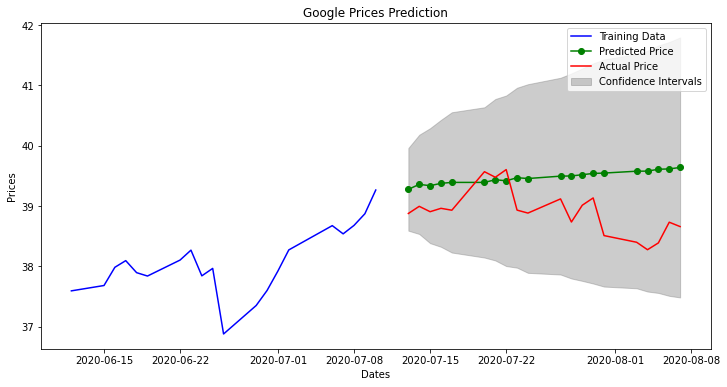

In [129]:
make_forecast(20)

### ARIMA

### TODO: Explain model and prep steps

Most of the models dealing with TimeSeries data work on the assumption that the data is stationary. Stationary means that it's statistical properties such as mean or standard deviation remain constant over time. We can assume the series to be stationary if it has constant statistical properties over time., i.e. the following:
- constant mean
- constant variance
- an autocovariance that doesn't depend on time

In the above graphs we could clearly see an overall increasing trend. We would not expect any seasonal patterns in this data but will also check for this later. To confirm our visual inspection we check for stationarity by using:
- **Plots of the rolling statistics**: We can plot the moving average and moving variance of the adjsuted closing price and see if it changes over time. Here we will use a timeframe of 7 days to catch possible weekly changes.
- **Dickey-Fuller test**: This is a statistical test to check stationarity. The *Null Hypothesis* is that the TimeSeries is not stationary. The results of this test are a *Test Statistic* and some *Critical Values* for different confidence levels. If the Test Statistic is smaller than the Critical Value we can reject the Null Hypothesis and say the series is stationary.

In [36]:
def check_stationarity(timeseries, interval=7):
    """
    Calculates rolling average and std. deviation for a series of adjusted closing prices.
    The function plots the results and prints the results of the Dickey-Fuller test.
    
    Arguments:
    symbol - string containing the stock symbol of the desired stock
    interval - timeframe to calculate rolling statistics
    Returns:
    df - dataframe with added rolling statistics
    """
    
    # add rolling statistics to dataframe  
    roll_avg = timeseries.rolling(interval).mean()
    roll_std = timeseries.rolling(interval).std()
    
    # plot adjusted closing price vs. rolling statistics
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=timeseries.index, y= timeseries, name='Original'))
    fig.add_trace(go.Scatter(x=timeseries.index, y= roll_avg, name='Rolling Average'))
    fig.add_trace(go.Scatter(x=timeseries.index, y= roll_std, name='Rolling Std Deviation'))
    fig.update_layout(title='Rolling Mean & Standard Deviation')
    fig.show()
    
    # Dickey-Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

From the graph we can tell that our rolling statistics change over time meaning they are not stationary. 
The results from the Dickey-Fuller test confirm our observation. The ADF statistic is way higher than any of our Critical Values here. It's safe to say our series is not stationary and there's some work to do to make it stationary.

In [87]:
df = ohlc_data['GOOG']
timeseries = np.log(df.adj_close)

In [88]:
moving_avg = timeseries.rolling(30).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=timeseries,
                    name='Log(adjusted closing price)'))
fig.add_trace(go.Scatter(x=df.index, y=moving_avg,
                    name='Moving Avg'))
fig.show()

ts_log_moving_avg_diff = timeseries - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

In [89]:
check_stationarity(ts_log_moving_avg_diff)

ADF Statistic: -7.161268187367239
p-value: 2.9638488134957504e-10
Critical Values:
	1%: -3.435761408287299
	5%: -2.863929614852828
	10%: -2.568042270495956


In [90]:
exp_weighted_avg = timeseries.ewm(halflife=30).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=timeseries,
                    name='Log(adjusted closing price)'))
fig.add_trace(go.Scatter(x=df.index, y=exp_weighted_avg,
                    name='Exp Moving Avg'))

ts_log_exp_avg_diff = timeseries - exp_weighted_avg
ts_log_exp_avg_diff.dropna(inplace=True)

In [91]:
check_stationarity(ts_log_exp_avg_diff)

ADF Statistic: -5.424000463699111
p-value: 3.01543946695949e-06
Critical Values:
	1%: -3.435634587707382
	5%: -2.8638736617392837
	10%: -2.568012472034339


In [92]:
ts_shift = timeseries - timeseries.shift(1)
ts_shift.dropna(inplace=True)
check_stationarity(ts_shift)

ADF Statistic: -8.58549594193792
p-value: 7.52699171217995e-14
Critical Values:
	1%: -3.4356260602190356
	5%: -2.863869899335344
	10%: -2.5680104683371323


In [41]:
def decompose_timeseries(timeseries, period=10):
    """
    Decompose timeseries in trend, seasonal and residual part.
    Plots graph for each partition of timeseries.
    
    Arguments:
    timeseries - timeseries to decompose
    period - timeframe to consider for decompopsition
    Returns:
    trend - trend timeseries w/o NaN values
    seasonal - seasonal series w/o NaN values
    residual - residual timeseries w/o NaN values
    """

    decomposition = seasonal_decompose(x=timeseries, period=period, model='multiplicative')

    trend = decomposition.trend.dropna()
#     trend.index = pd.DatetimeIndex(trend.index).to_period('D')
    seasonal = decomposition.seasonal.dropna()
#     seasonal.index = pd.DatetimeIndex(seasonal.index).to_period('D')
    residual = decomposition.resid.dropna()
#     residual.index = pd.DatetimeIndex(residual.index).to_period('D')

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=timeseries, name='Original'))
    fig.add_trace(go.Scatter(x=df.index, y=trend, name='Trend'))
    fig.add_trace(go.Scatter(x=df.index, y=seasonal, name='Seasonality'))
    fig.add_trace(go.Scatter(x=df.index, y=residual, name='Residuals'))
    fig.show()
    
    return trend, seasonal, residual

In [43]:
trend, seasonal, residual = decompose_timeseries(y_train, 2)

NameError: name 'df' is not defined

In [95]:
check_stationarity(residual)

ADF Statistic: -9.924040510338873
p-value: 2.9390770874696545e-17
Critical Values:
	1%: -3.4357658900670085
	5%: -2.8639315921664568
	10%: -2.5680433235434736


### AutoRegressive model (AR):
AR models operate under the assumption that previous values have an impact on current values. As long as the assumptions holds we're able to predict a value of a dependent variable today, given the values it had in the past. The order of the AR model corresponds to the number of previous values taken into account.

### Moving Average Model (MA)
The MA model assumes that the current value of the dependent variable is related to the previous days error terms. The number of previous errors to be considered is called the order of the MA model. E.g. if we assume an order of 3, we would consider *e(t-3), e(t-2) and e(t-1)* as inputs for our regressor with *e(i) = moving_average(i) - actual_value(i)*

### Auto Regressive Moving Average (ARMA):
Is the combination of the above two models.

### ARIMA model

ARIMA stands for *AutoRegressor Integrated Moving Average* and is a regression model. It adds differencing to the ARMA model and can be used to transform a timeseries into a stationary series. First order differencing smoothes linear trends in the data by the transformation $$ z_i = y_i - y_{i-1}$$ whereas second order differencing adreses quadratic trends and so on.

The features are desccribed by the parameters p, d and q as follows:

 - p: number of previous values to take into account for the current estimation (AR order)
 - d: number describing the differencig order
 - q: number of previous errors (MA order)
 
To determine the values for p and q we use plots for *ACF* and *PACF*.

#### Auto correlation function (ACF):
This metric expresses the correlation between the observations at the current point in time and the observations at all previous points in time. We use ACF to determine the **number of optimal Moving Average (MA) terms**. 

#### Partial  Auto correlation function (PACF):
PACG expresses the correlation between observations made at two points in time while accounting for any influence from other data points. We sue PACF to determine the **optimal number of Autoregressive terms** in our model. 

In [96]:
def check_auto_correlation(timeseries, n_lags):
    """
    Calculates and plots Autocorrelation function (ACF) & Partial Autocorrelation function (PACF).
    Plots the results and the related confidence interval.
    """
        
    lag_acf, conf_array = acf(timeseries, nlags=n_lags, fft=True, alpha=0.05)
    upper = conf_array[:, 1] - lag_acf
    lower = conf_array[:, 0] - lag_acf
    lag_pacf = pacf(timeseries, nlags=n_lags, method='ols')

    # Plot ACF & PACF
    x = list(range(1,n_lags))
    x_rev = x[::-1]
    lower = lower[::-1]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=lag_acf, name='ACF'))
    fig.add_trace(go.Scatter(x=x, y=lag_pacf, name='PACF'))
    fig.add_trace(go.Scatter(x=x, y=upper, name='upper conf-int',
                            mode='lines', fill='tozeroy'))
    fig.add_trace(go.Scatter(x=x, y=lower[::-1], name='lower conf-int',
                            mode='lines', fill='tozeroy'))
    fig.show()

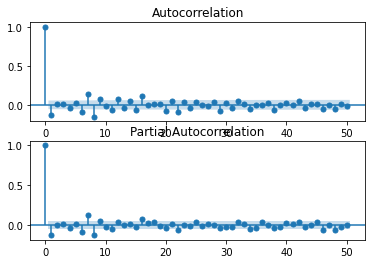

In [97]:
fig, ax = plt.subplots(2)
ax[0] = plot_acf(ts_shift, lags=50, ax=ax[0])
ax[1] = plot_pacf(ts_shift, lags=50, ax=ax[1])

In [99]:
check_auto_correlation(ts_shift, 10)

As descried above we use ACF respectivly PACF for finding our parameters p and q. For both terms we look in the above graph for the value where ACF/ PACF cut the confidence interval for the first time. As we can only choose intergers as input for our model we choose a value of 2 for p and q.

In [81]:
p, d, q = 2, 1, 2

In [103]:
def plot_fitting(residual, model_results):
    """Plots the residual values vs the fitted values for comparison."""
    
    if model_results.k_ar != 0 & model_results.k_ma == 0:
        model_type = 'AR Model'
    elif model_results.k_ar == 0 & model_results.k_ma != 0:
        model_type = 'MA Model'
    else: 
        model_type = 'ARIMA model'
    sse = sum((model_results.fittedvalues-residual)**2)
        
    x = residual.index#.to_timestamp()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=residual, name='Residuals'))
    fig.add_trace(go.Scatter(x=x, y=model_results.fittedvalues, name='Fitted Values'))
    fig.update_layout(title='{} \t-\t SSE: {:.4f}'.format(model_type, sse))
    fig.show()

In [112]:
def train_arima(timeseries, p, d, q):
    """
    Trains the ARIMA model with the given timeseries and plots the results.
    Arguments:
    timeseries - stationary timeseries to train the model
    p - {int}: number of previous values to take into account
    d - {int}: number describing the differencing order
    q - {int}: number of previous errors
    Returns:
    results_ARIMA: object containing ARIMAResults
    """

    # AR model
    model = ARIMA(timeseries, order=(p, d, 0))  
    results_AR = model.fit(disp=-1)  
    plot_fitting(timeseries, results_AR)

    # MA model
    model = ARIMA(timeseries, order=(0, d, q))  
    results_MA = model.fit(disp=-1)  
    plot_fitting(timeseries, results_MA)

    # combined ARIMA model
    model = ARIMA(timeseries, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    plot_fitting(timeseries, results_ARIMA)

In [125]:
train_arima(ts_log_moving_avg_diff, p, d, q)

C:\Users\yvesd\miniconda3\envs\stocks\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\yvesd\miniconda3\envs\stocks\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



C:\Users\yvesd\miniconda3\envs\stocks\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\yvesd\miniconda3\envs\stocks\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



C:\Users\yvesd\miniconda3\envs\stocks\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\yvesd\miniconda3\envs\stocks\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [111]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

common_idx = reduce(np.intersect1d, (residual.index, trend.index, seasonal.index, predictions_ARIMA_diff_cumsum.index))
agg_values = reduce(np.add, (residual[common_idx], predictions_ARIMA_diff_cumsum[common_idx], trend[common_idx], seasonal[common_idx]))

predictions_ARIMA  = np.exp(agg_values)
rmse = np.sqrt(sum((predictions_ARIMA-np.exp(timeseries[common_idx]))**2)/len(timeseries[common_idx]))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=np.exp(timeseries), name='Original'))
fig.add_trace(go.Scatter(x=x, y=predictions_ARIMA, name='Predicition'))
fig.update_layout(title='RMSE: {:.4f}'.format(rmse))

AttributeError: 'NoneType' object has no attribute 'fittedvalues'

From the chart above we can tell that our predicted values are quite far away from the original data. This is confirmed by an RMSE of ~180. A prediction that can be that far from the actual value is not acceptable for stock prices.

## LSTM